We have two cameras, that haven taken non-synchronised photos.

For each photo we get a vector from the camera that passes through the bee. 

Can we reconstruct the path of the bee (with obvious uncertainty).

Here we assume the bee's latent (true) flight, follows a 3-output Gaussian process, with an EQ kernel. 

The likelihood is a Normal distribution over the distance of the point from the vector at that observation. (this is sort of backwards in some sense, P(data|model) vs P(model|data)... Might have to think about this.

At the stochastic VI step, we sample from a 3 dimensional Gaussian, so the dependencies between the three axes are represented in the samples.

In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

In [29]:
def K(X1,X2):
    """
    Our kernel. An EQ kernel (ls=2, scale=10^2). The prior is UNCORRELATED between dimensions.
    """
    cov = 100*np.exp(-np.sum(np.subtract(X1[:,None],X2[None,:])**2/(2*2.0**2),2))
    axsel = tf.cast((X1[:,1][:,None]==X2[:,1][None,:]),dtype=tf.float32)
    cov = cov * axsel
    return cov

In [30]:
def buildinputmatrix(min_time,max_time,size):
    """
    Constructs a matrix of [3*size,2], where the first column is time and second is axis (x,y,z).
    """
    A = []
    for ax in range(3):
        Aax = np.c_[np.linspace(min_time,max_time,size),np.full(size,ax)]
        A.extend(Aax)
    A = np.array(A)
    A = tf.Variable(A,dtype=tf.float32)    
    return A

def buildoutputmatrix(X):
    """Builds synthetic dataset, based on input X. If X is [3*size,2] this will be [size,6].
    The first three columns represent the camera location, the last three a (unit) vector pointing at the bee."""
    size = int(X.shape[0]/3)
    cam =np.random.choice([True, False],size)
    actual = tf.concat([tf.math.cos(X[:size,0:1]),tf.math.sin(X[:size,0:1]),X[:size,0:1]/4],axis=1)
    camera = tf.where(cam[:,None] ,np.array([[2.0,0,0]],dtype=np.float32),np.array([[0.0,2,0]],dtype=np.float32))
    vect = actual-camera
    vect = vect/np.linalg.norm(vect,axis=1)[:,None]
    return tf.concat([camera,vect],axis=1),actual


In [31]:
#Build the inducing point locations:
Z = buildinputmatrix(0,10,10)

#Build the synthetic data:
X = buildinputmatrix(0,10,30)
y,actual = buildoutputmatrix(X)

In [102]:
def cross(a,b):
    """
    Compute cross product with batching. Currently only allows particular number of dimensions in the input...
    a - [!,3] tensor
    b - [*,!,3] tensor
    e.g.
    a.shape = [20,3]
    b.shape = [15,20,3]
    result.shape = [15,20,3]
    TODO: Generalise for any compatible input batch shapes
    """
    #print(a.shape,b.shape)
    size = a.shape[0]
    A = tf.Variable([[tf.zeros(size), -a[:,2], a[:,1]],[a[:,2], tf.zeros(size), -a[:,0]],[-a[:,1], a[:,0],tf.zeros(size)]])
    A = tf.transpose(A,[2,0,1])
    A = A[None,:,:,:]
    b = b[:,:,:,None]
    return (A@b)[:,:,:,0]

In [107]:
#number of inducing points.
m = Z.shape[0]
#create variables that describe q(u), the variational distribution.
mu = tf.Variable(tf.random.normal([m]))
scale = tf.Variable(tf.random.normal([m, m]))

#parameters for p(u), the prior.
mu_u = tf.zeros([1,m])
cov_u = tf.Variable(K(Z,Z))
pu = tfd.MultivariateNormalFullCovariance(mu_u,cov_u+np.eye(cov_u.shape[0])*0.01)

#We don't optimise the hyperparameters, so precompute.
invKzz = tf.linalg.inv(K(Z,Z)+np.eye(Z.shape[0],dtype=np.float32)*0.01)
#TODO: Painfully unstable - will copy stable version from other VI code soon.!!

size = int(X.shape[0]/3) #number of input points

for it in range(300):
    with tf.GradientTape() as tape:
        
        #the variational approximating distribution.
        qu = tfd.MultivariateNormalTriL(mu,scale) 
        
        #compute the approximation over our training point locations
        #TODO only need some diagonals and off diagonal parts of qf_cov, so prob could be quicker!
        qf_mu = K(X,Z) @ invKzz @ mu[:,None]
        qf_cov = K(X,X) - K(X,Z) @ invKzz @ K(Z,X) + K(X,Z)@ invKzz @(scale@tf.transpose(scale))@ invKzz @ K(Z,X)
        
        
        #this gets us the covariance and mean for the relevant parts of the predictions. Specifically
        #a 3x3 covariance and a 3-element mean.
        C = tf.transpose(tf.concat([qf_cov[i::size,i::size][:,:,None] for i in range(size)],axis=2),[2,0,1])
        M = tf.transpose(tf.reshape(qf_mu,[3,size]),[1,0])
        Nsamps = 500
        
        jitter = tf.eye(3)*1e-8
        for jitteri in range(6):
            try:
                #we sample from the multivariate Gaussian our variational distribution,q, predicts for
                #all of the observation locations in X.
                samps = tfd.MultivariateNormalTriL(M,tf.linalg.cholesky(C+jitter)).sample(Nsamps)
                break
            except tf.errors.InvalidArgumentError:
                jitter*=10
            
        #we compute the distance from each of the observed vectors to the samples and compute their
        #log likelihoods assuming a normal distributed likelihood model over the distance from the
        #vector.
        d = tf.norm(cross(y[:,3:],samps-y[:,:3]),axis=2)/tf.norm(y[:,3:],axis=1)
        logprobs = tfd.Normal(0,0.02).log_prob(d)
        ell = tf.reduce_mean(tf.reduce_sum(logprobs,1))
        
        #we compute the ELBO = - (expected log likelihood of the data - KL[prior, variational_distribution]).
        elbo_loss = -( ell - tfd.kl_divergence(qu,pu) )
    #compute gradients and optimise...
    gradients = tape.gradient(elbo_loss, [mu, scale])
    optimizer.apply_gradients(zip(gradients, [mu, scale]))
    if it%20 == 0: print(it,elbo_loss.numpy())

0 [2113161.]
20 [129293.22]
40 [19321.186]
60 [4940.953]
80 [2670.439]
100 [2463.912]
120 [2298.968]
140 [2210.61]
160 [2200.377]
180 [2087.767]
200 [2078.531]
220 [2022.839]
240 [2035.984]
260 [2032.934]
280 [2009.863]


In [108]:
#compute the predictions for some test points in Xtest.
Xtest = buildinputmatrix(0,10,500)
qf_mu = K(Xtest,Z) @ invKzz @ mu[:,None]
#need to solve in a numerically stable manner.
qf_cov = K(Xtest,Xtest) - K(Xtest,Z) @ invKzz @ K(Z,Xtest) + K(Xtest,Z)@ invKzz @(scale@tf.transpose(scale))@ invKzz @ K(Z,Xtest)

Here are the posterior MEANS and true (dashed and of same colour) path.

Text(0.5, 0, 'Time')

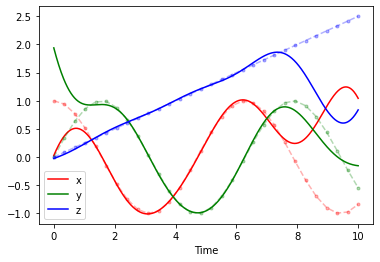

In [113]:
lab = ['x','y','z']
lt = ['r','g','b']
testsize = int(Xtest.shape[0]/3)
for i in range(3):
    plt.plot(Xtest.numpy()[:testsize,0],qf_mu[(i*testsize):((i+1)*testsize),0],lt[i],label=lab[i])
    plt.plot(X.numpy()[:size,0],actual.numpy()[:,i],'--.'+lt[i],alpha=0.3)
plt.legend()
plt.xlabel('Time')

To properly visualise the uncertainty, we sample from the posterior and plot them in 3d.

In [114]:
C = tf.transpose(tf.concat([qf_cov[i::testsize,i::testsize][:,:,None] for i in range(testsize)],axis=2),[2,0,1])
M = tf.transpose(tf.reshape(qf_mu,[3,testsize]),[1,0])
Nsamps = 100
jitter = tf.eye(3)*1e-2
samps = tfd.MultivariateNormalFullCovariance(M,(C+jitter)/10).sample(Nsamps)

In [116]:
import ipyvolume as ipv

In [117]:
ipv.clear()
def plot(mat):
    ipv.plot(mat[...,0],mat[...,1],mat[...,2],color='green')
def scatter(mat):
    ipv.scatter(mat[...,0],mat[...,1],mat[...,2],size=1,marker='sphere',color='black')
def plotlines(start,end):
    for s,e in zip(start,end):
        ipv.plot([s[0],e[0]],[s[1],e[1]],[s[2],e[2]])
#plot(samps[0,:,:].numpy())
for i in range(20):
    scatter(samps[i,:400,:])
#plot(np.mean(samps,0))
#plot(tf.transpose(samps,[1,0,2]).numpy())
plotlines(y[:,:3].numpy(),(y[:,:3]+y[:,3:]*3).numpy())
plot(actual)
box = 2
ipv.xlim(-box,box)
ipv.ylim(-box,box)
ipv.zlim(0,box)
ipv.show()